In [1]:
# Tool Setup

%load_ext tensorboard

import pathlib, os, sys, operator, re, datetime

from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Model
import tensorflow_datasets as tfds
import h5py
import pandas as pd

# Use seaborn for pairplot.
# pip install -q seaborn

import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.19.0


In [2]:
url = 'p:\Mitchell\FFNeuralNetwork\statsTraining.csv'

raw_dataset = pd.read_csv(url, na_values='?', comment='\t', skipinitialspace=True)

dataset = raw_dataset.copy()
# dataset.tail()

In [3]:
dataset.isna().sum()
dataset = dataset.fillna(0)

# dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

dataset.tail()

,Age,Previous Rank,FantPos,Games Played,Games Started,Cmp,Att,Yds,TD,Int,Rush Att,Rush Yds,Rush TD,Tgt,Rec,Rec Yds,Rec TD,Total TD,PPR,Rank
3241,27,368,2,7,0,0.0,0.0,0.0,0.0,0.0,13.0,-13.0,0.0,0.0,0.0,0.0,0.0,0,-1.3,0.993671
3242,24,205,0,4,1,0.0,0.0,0.0,0.0,0.0,14.0,16.0,0.0,6.0,5.0,14.0,0.0,0,4.0,0.995253
3243,28,0,3,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,-10.0,0.0,0,1.0,0.996835
3244,27,484,1,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0,-2.0,0.998418
3245,29,455,1,17,0,0.0,0.0,0.0,0.0,0.0,1.0,-2.0,0.0,2.0,0.0,0.0,0.0,0,-2.2,1.000000


In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# sns.pairplot(train_dataset, diag_kind='kde')

train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Age,2597.0,26.093570,3.250949,21.000000,24.000000,25.000000,28.00,45.0
Previous Rank,2597.0,205.048518,197.298472,0.000000,0.000000,160.000000,356.00,692.0
FantPos,2597.0,1.396611,1.146693,0.000000,1.000000,1.000000,2.00,4.0
Games Played,2597.0,10.653061,5.424450,0.000000,6.000000,12.000000,16.00,17.0
Games Started,2597.0,4.904890,5.572035,0.000000,0.000000,2.000000,9.00,17.0
Cmp,2597.0,17.860608,69.332653,0.000000,0.000000,0.000000,0.00,490.0
Att,2597.0,27.716596,106.257452,0.000000,0.000000,0.000000,0.00,733.0
Yds,2597.0,197.302272,771.080809,-1.000000,0.000000,0.000000,0.00,5316.0
TD,2597.0,1.209087,5.090758,0.000000,0.000000,0.000000,0.00,48.0
Int,2597.0,0.636504,2.453957,0.000000,0.000000,0.000000,0.00,30.0


In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Previous Rank')
test_labels = test_features.pop('Previous Rank')

In [6]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Age,26.093570,3.250949
Previous Rank,205.048518,197.298472
FantPos,1.396611,1.146693
Games Played,10.653061,5.424450
Games Started,4.904890,5.572035
Cmp,17.860608,69.332653
Att,27.716596,106.257452
Yds,197.302272,771.080809
TD,1.209087,5.090758
Int,0.636504,2.453957


In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[ 26.094   1.397  10.653   4.905  17.861  27.717 197.302   1.209   0.637
   22.374  97.328   0.769  26.427  17.711 195.123   1.208   1.995  69.844
    0.503]]
First example: [[ 28.     1.    12.     1.     0.     0.     0.     0.     0.     0.
    0.     0.    22.    21.   227.     2.     2.    55.7    0.42]]

Normalized: [[ 0.59 -0.35  0.25 -0.7  -0.26 -0.26 -0.26 -0.24 -0.26 -0.42 -0.41 -0.36
  -0.12  0.14  0.11  0.37  0.   -0.17 -0.3 ]]


C:\Users\mdriscoll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
CPU times: total: 0 ns
Wall time: 0 ns
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


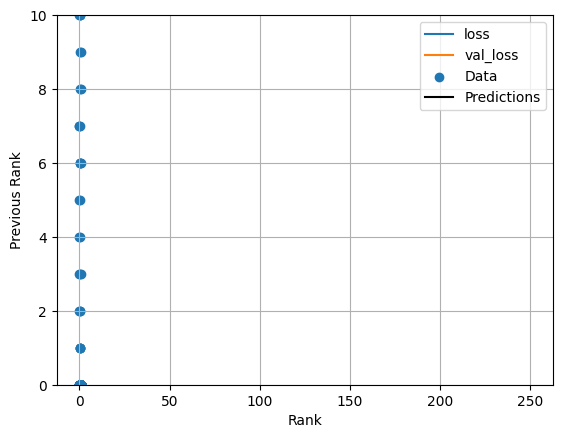

In [8]:
Rank = np.array(train_features['Rank'])

Rk_normalizer = layers.Normalization(input_shape=[1,], axis=None)
Rk_normalizer.adapt(Rank)

Rk_model = tf.keras.Sequential([
    Rk_normalizer,
    layers.Dense(units=1)
])

Rk_model.summary()

Rk_model.predict(Rank[:10])

Rk_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

%time
history = Rk_model.fit(
    train_features['Rank'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Previous Rank]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

test_results = {}

test_results['Rk_model'] = Rk_model.evaluate(
    test_features['Rank'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = Rk_model.predict(x)

def plot_Rk(x, y):
  plt.scatter(train_features['Rank'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Rank')
  plt.ylabel('Previous Rank')
  plt.legend()

plot_Rk(x, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
CPU times: total: 0 ns
Wall time: 0 ns


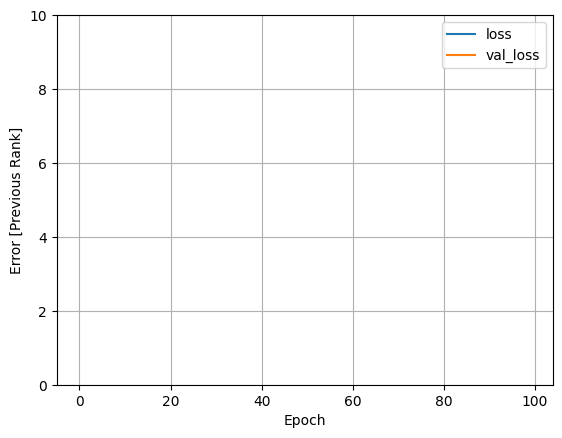

In [9]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

CPU times: total: 0 ns
Wall time: 0 ns
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026B4A5816C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 19)               │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39 (160.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 39 (160.00 B)

CPU times: total: 0 ns
Wall time: 0 ns


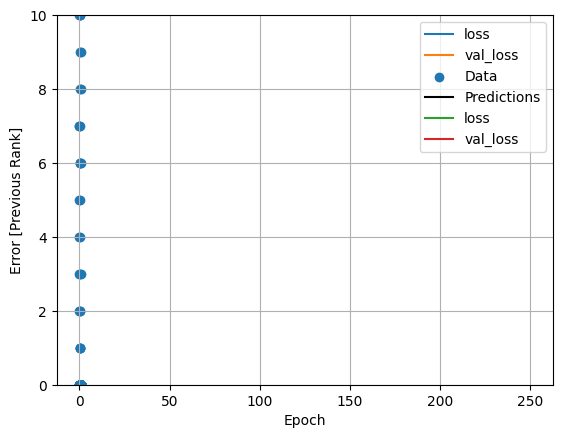

In [10]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_horsepower_model = build_and_compile_model(Rk_normalizer)

dnn_horsepower_model.summary()

%time
history = dnn_horsepower_model.fit(
    train_features['Rank'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_Rk(x, y)

test_results['dnn_rank_model'] = dnn_horsepower_model.evaluate(
    test_features['Rank'], test_labels,
    verbose=0)

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Mean absolute error [Previous Rank]
Rk_model,159.985825
linear_model,152.834076
dnn_rank_model,159.953690
dnn_model,139.735367
reloaded,139.735367


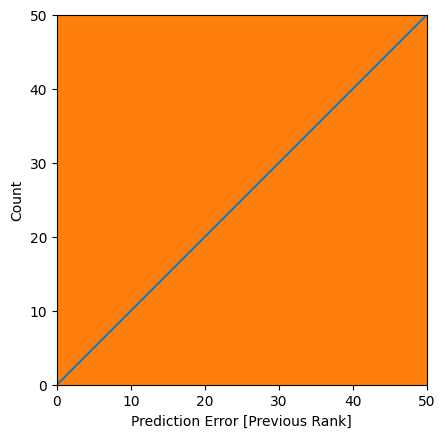

In [11]:
pd.DataFrame(test_results, index=['Mean absolute error [Previous Rank]']).T

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Previous Rank]')
plt.ylabel('Predictions [Previous Rank]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Previous Rank]')
_ = plt.ylabel('Count')

dnn_model.save('dnn_model.keras')

reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [Previous Rank]']).T